<a href="https://colab.research.google.com/github/ncshin/intro-ml-course-winter2026/blob/main/Course%20Project%20Phase%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
from google.colab import files
from google.colab import drive

In [ ]:
import pandas as pd
import numpy as np
import warnings
import os
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from imblearn.combine import SMOTETomek

warnings.filterwarnings('ignore')

# Import Data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import dataset

dir = "/content/drive/My Drive/Colab Notebooks/HAD5016/Datathons"  # <-- change to your folder

# "/content/drive/My Drive/MPH/MPH/Winter 2026/5016 Machine Learning/HAD5016 Course Project" # Nathan's
# "/content/drive/My Drive/Colab Notebooks/HAD5016/Datathons" => Urim's
# "/content/drive/My Drive/..." => Vy's

filename = "TMU_DM_808K_R1.csv"  # <-- confirm the file name
in_path = os.path.join(dir, filename)

In [ ]:
df = pd.read_csv(in_path)

In [ ]:
df.head()

,Age_at_Exam,Sex,sBP,sBP_Date,BMI,BMI_Date,LDL,LDL_Date,HDL,HDL_Date,...,duration_b_R1_[corticosteroid]_Days,total_b_R1_[corticosteroid]_Records,first_b_R1_[1stlineantidiabetic],first_StartDate_b_R1_[1stlineantidiabetic],first_StopDate_b_R1_[1stlineantidiabetic],last_b_R1_[1stlineantidiabetic],last_StartDate_b_R1_[1stlineantidiabetic],last_StopDate_b_R1_[1stlineantidiabetic],duration_b_R1_[1stlineantidiabetic]_Days,total_b_R1_[1stlineantidiabetic]_Records
0,69,Male,140.0,2010-03-18,26.000000,2010-12-17,3.35,2010-03-06,1.03,2010-03-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,56,Female,120.0,2011-11-03,24.000000,2011-11-03,4.01,2011-10-04,1.84,2011-10-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,35,Female,100.0,2014-02-21,51.195667,2014-02-21,3.11,2014-02-24,1.26,2014-02-24,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,43,Female,138.0,2013-07-04,67.794421,2013-07-04,2.96,2013-08-02,1.09,2013-08-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,49,Male,141.0,2013-03-13,34.000000,2013-01-24,4.06,2013-01-24,1.34,2013-01-24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_cad = df[df['[CAD)'].isin([0, 1])]
df_cad.shape

(102736, 175)

In [ ]:
cols = [
    'Patient_ID', 'sBP_Date', 'Age_at_Exam', 'Sex',
    'LDL', 'LDL_Date',
    'HDL', 'HDL_Date',
    'TG', 'TG_Date',
    'BMI', 'BMI_Date',
    '[Anxiety)', '[Anxiety_Date]',
    '[Depression)', '[Depression_Date]',
    '[CAD)', '[CAD_Date]'
]
# TG is probably mmol/L
df_selected = df_cad[cols]

In [ ]:
# Sort df_selected by Patient_ID in ascending order
df_sorted = df_selected.sort_values(by='Patient_ID', ascending=True)

# Print the top 20 entries
# print(df_sorted.head(20))


duplicates = df_selected['Patient_ID'].duplicated().sum()
print(duplicates) # number of duplicates

85546


In [ ]:
df_selected.dtypes

,0
Patient_ID,int64
sBP_Date,object
Age_at_Exam,int64
Sex,object
LDL,float64
LDL_Date,object
HDL,float64
HDL_Date,object
TG,float64
TG_Date,object


In [ ]:
df_selected.shape

(102736, 18)

# Data Preprocessing: Cleaning, EDA, & Feature Engineering

In [ ]:
# Using the map() function to transform the 'Sex' column
df_selected['Sex'] = df_selected['Sex'].map({'Male': 0, 'Female': 1})

In [ ]:
# Ensure the date column is actually a datetime object
df_selected['sBP_Date'] = pd.to_datetime(df_selected['sBP_Date'])

In [ ]:
# Sort by Patient_ID (ascending) and Date (descending)
# This puts the most recent date for each patient at the top
df_sorted = df_selected.sort_values(
    by=['Patient_ID', 'sBP_Date'],
    ascending=[True, False] )

#Drop duplicates, keeping only the first occurrence for each Patient_ID
# Since we sorted descending by date, the 'first' is the most recent
df_most_recent = df_sorted.drop_duplicates(subset='Patient_ID', keep='first')

In [ ]:
df_most_recent.head()

,Patient_ID,sBP_Date,Age_at_Exam,Sex,LDL,LDL_Date,HDL,HDL_Date,TG,TG_Date,BMI,BMI_Date,[Anxiety),[Anxiety_Date],[Depression),[Depression_Date],[CAD),[CAD_Date]
283550,1001000000004140,2007-05-17,63,1,3.12,2007-05-23,2.35,2007-05-23,0.92,2007-05-23,23.422091,2007-05-17,0.0,NaN,0.0,NaN,0.0,NaN
287455,1001000000007276,2008-04-07,51,1,4.05,2008-04-11,1.76,2008-04-11,0.55,2008-04-11,25.200000,2008-04-07,1.0,2012-11-23,1.0,2014-08-28,0.0,NaN
270245,1001000000011757,2013-03-19,46,1,2.14,2013-03-13,1.22,2013-03-13,0.71,2013-03-13,26.400000,2013-03-19,0.0,NaN,0.0,NaN,0.0,NaN
708898,1001000000012561,2014-01-14,74,1,3.43,2013-09-12,0.86,2013-12-17,1.68,2013-12-17,28.800000,2013-09-17,1.0,2009-11-27,0.0,NaN,0.0,NaN
272162,1001000000013745,2006-09-19,40,1,3.98,2006-09-23,1.27,2006-09-23,2.95,2006-09-23,30.000000,2006-01-20,1.0,2013-09-23,1.0,2005-08-16,0.0,NaN


In [ ]:
df_most_recent.shape

(17190, 18)

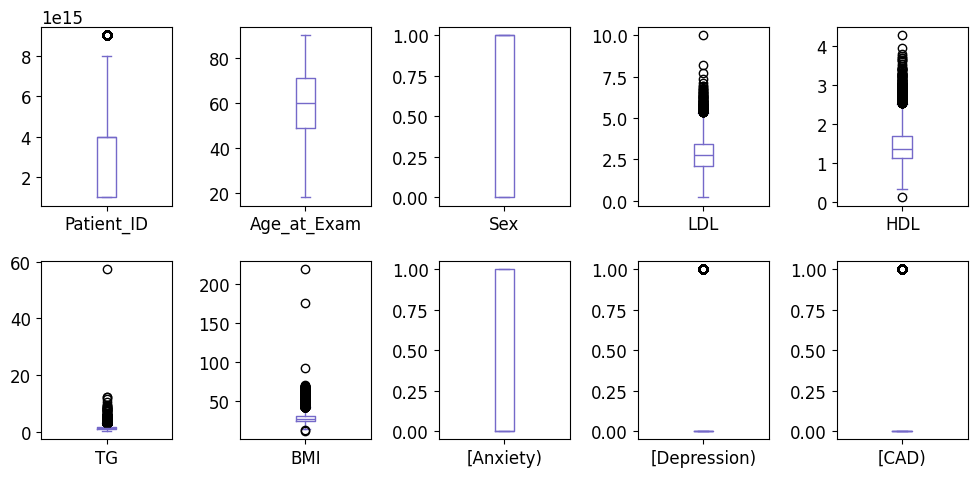

In [ ]:
df_most_recent.plot(kind='box', subplots=True, layout=(2, 5), figsize=(10, 5), color='#7569c9')
plt.tight_layout()
plt.show()

In [ ]:
cols = ['LDL', 'HDL', 'TG', 'BMI']

outlier_counts = {}

for col in cols:
    Q1 = df_most_recent[col].quantile(0.25)
    Q3 = df_most_recent[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_most_recent[(df_most_recent[col] < lower_bound) |
                               (df_most_recent[col] > upper_bound)]

    outlier_counts[col] = len(outliers)

outlier_counts

{'LDL': 123, 'HDL': 310, 'TG': 768, 'BMI': 549}

In [ ]:
df_most_recent.describe()

,Patient_ID,sBP_Date,Age_at_Exam,Sex,LDL,HDL,TG,BMI,[Anxiety),[Depression),[CAD)
count,1.719000e+04,17190,17190.000000,17190.000000,17139.000000,17013.000000,17016.000000,17190.000000,17190.000000,17190.000000,17190.000000
mean,3.255958e+15,2012-11-18 22:01:53.089005312,59.428447,0.638860,2.803839,1.442995,1.376965,28.573179,0.357766,0.219488,0.050204
min,1.001000e+15,2003-11-14 00:00:00,18.000000,0.000000,0.200000,0.130000,0.210000,11.527430,0.000000,0.000000,0.000000
25%,1.003000e+15,2011-09-27 00:00:00,49.000000,0.000000,2.120000,1.130000,0.850000,24.300000,0.000000,0.000000,0.000000
50%,4.001000e+15,2013-05-10 00:00:00,60.000000,1.000000,2.750000,1.380000,1.180000,27.593916,0.000000,0.000000,0.000000
75%,4.001000e+15,2014-07-24 00:00:00,71.000000,1.000000,3.410000,1.690000,1.680000,31.490000,1.000000,0.000000,0.000000
max,9.001000e+15,2015-06-30 00:00:00,90.000000,1.000000,10.000000,4.280000,57.340000,218.700000,1.000000,1.000000,1.000000
std,1.910427e+15,NaN,15.280139,0.480345,0.930343,0.428343,0.898813,6.571702,0.479357,0.413912,0.218371


In [ ]:
df_most_recent = df_most_recent[['Age_at_Exam', 'Sex', 'LDL', 'HDL', 'TG', 'BMI', '[Anxiety)', '[Depression)', '[CAD)']]

In [ ]:
# List of columns that are intended to be dropped from the dataset
dropping_columns = ['Patient_ID', 'LDL_Date', 'HDL_Date', 'TG_Date', 'BMI_Date', '[Anxiety_Date]', '[Depression_Date]', '[CAD_Date]']

# Checking the number of missing values (NaN) in the columns
df_most_recent.isnull().sum()


,0
Age_at_Exam,0
Sex,0
LDL,51
HDL,177
TG,174
BMI,0
[Anxiety),0
[Depression),0
[CAD),0


In [ ]:
print(df_most_recent['LDL'].describe())

count    17139.000000
mean         2.803839
std          0.930343
min          0.200000
25%          2.120000
50%          2.750000
75%          3.410000
max         10.000000
Name: LDL, dtype: float64


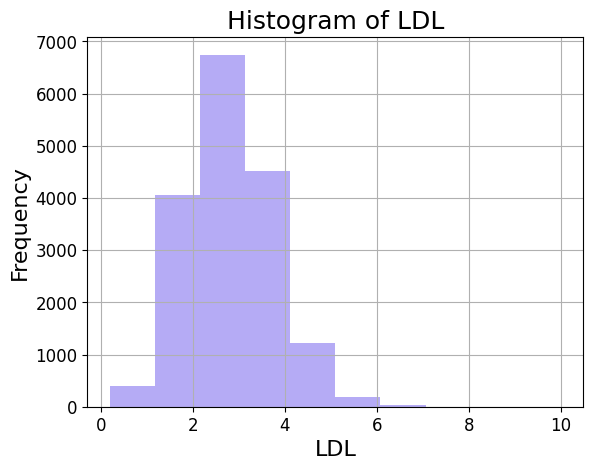

In [ ]:
# Create a histogram for the 'LDL' column with a custom color
df_most_recent['LDL'].hist(color='#b5abf5')  # Using a shade of purple as an example color
plt.xlabel('LDL')  # Label for the x-axis
plt.ylabel('Frequency')     # Label for the y-axis
plt.title('Histogram of LDL')  # Title for the histogram
plt.show()  # Display the histogram

In [ ]:
print(df_most_recent['HDL'].describe())

count    17013.000000
mean         1.442995
std          0.428343
min          0.130000
25%          1.130000
50%          1.380000
75%          1.690000
max          4.280000
Name: HDL, dtype: float64


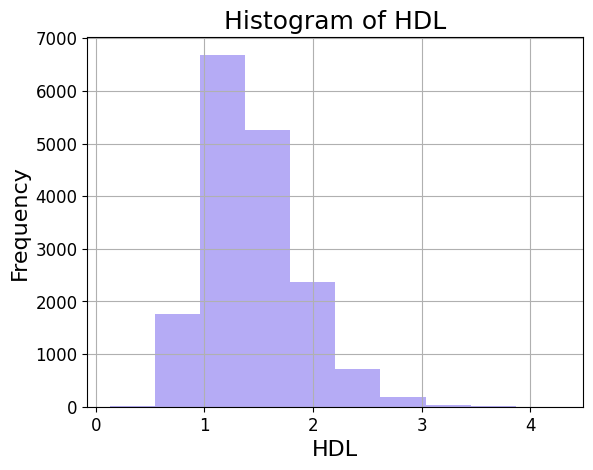

In [ ]:
# Create a histogram for the 'HDL' column with a custom color
df_most_recent['HDL'].hist(color='#b5abf5')  # Using a shade of purple as an example color
plt.xlabel('HDL')  # Label for the x-axis
plt.ylabel('Frequency')     # Label for the y-axis
plt.title('Histogram of HDL')  # Title for the histogram
plt.show()  # Display the histogram

In [ ]:
print(df_most_recent['TG'].describe())

count    17016.000000
mean         1.376965
std          0.898813
min          0.210000
25%          0.850000
50%          1.180000
75%          1.680000
max         57.340000
Name: TG, dtype: float64


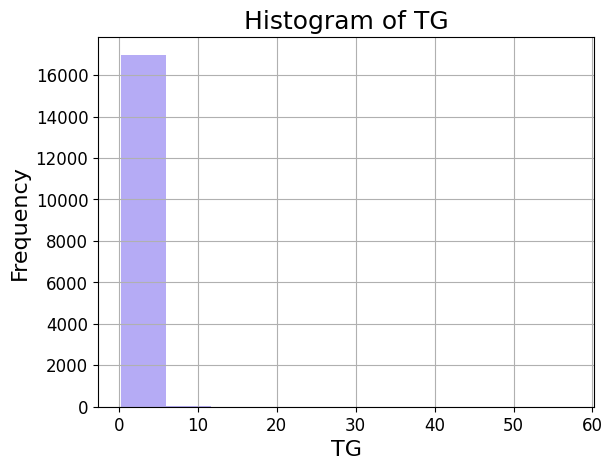

738882    57.34
62991     12.29
551295    12.16
505564    11.64
699066    10.32
776114     9.31
227205     9.26
554629     8.94
401639     8.82
405448     8.81
Name: TG, dtype: float64


In [ ]:
# Create a histogram for the 'TG' column with a custom color
df_most_recent['TG'].hist(color='#b5abf5')  # Using a shade of purple as an example color
plt.xlabel('TG')  # Label for the x-axis
plt.ylabel('Frequency')     # Label for the y-axis
plt.title('Histogram of TG')  # Title for the histogram
plt.show()  # Display the histogram
print(df_most_recent['TG'].nlargest(10))

# Missing Values Assessment

In [ ]:
df_most_recent.isnull().sum()

,0
Age_at_Exam,0
Sex,0
LDL,51
HDL,177
TG,174
BMI,0
[Anxiety),0
[Depression),0
[CAD),0


In [ ]:
# List of unique categories within the 'Sex' column..
missing_Sex = df_most_recent['Sex'].unique()
missing_Sex

array([1, 0])

In [ ]:
# Explore the unique values in the 'Age_at_Exam' column
df_most_recent['Age_at_Exam'].unique()

array([63, 51, 46, 74, 40, 45, 70, 37, 54, 64, 32, 52, 82, 48, 57, 77, 50,
       38, 53, 67, 60, 61, 73, 80, 58, 33, 44, 72, 87, 62, 75, 39, 42, 65,
       78, 29, 71, 34, 55, 41, 49, 47, 19, 83, 68, 22, 66, 84, 79, 43, 28,
       31, 56, 26, 59, 25, 36, 69, 76, 35, 30, 89, 88, 86, 85, 90, 81, 24,
       27, 21, 23, 20, 18])

In [ ]:
# Calculate the percentage of rows with one or more missing values
percentage_missing_rows = (df_most_recent.isnull().sum(axis=1) > 0).sum() / len(df_most_recent)
percentage_missing_rows

np.float64(0.02006980802792321)

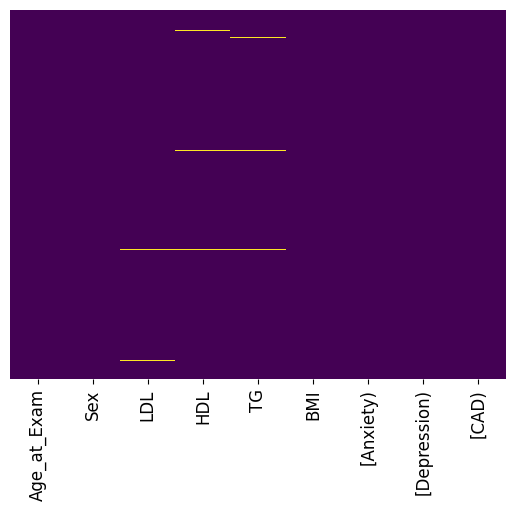

In [ ]:
sns.heatmap(df_most_recent.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.show()

In [ ]:
df_most_recent['is_LDL_na'] = df_most_recent['LDL'].isna().astype(int)

data_male = df_most_recent[df_most_recent['Sex'] == 0]
ldl_cad_tableM = pd.crosstab(data_male['is_LDL_na'], data_male['[CAD)'])
print("\nMale Counts:")
print(ldl_cad_tableM)
print("\nM Row %:")
print(pd.crosstab(data_male['is_LDL_na'], data_male['[CAD)'], normalize='index').round(3))

data_female = df_most_recent[df_most_recent['Sex'] == 1]
ldl_cad_tableF = pd.crosstab(data_female['is_LDL_na'], data_female['[CAD)'])
print("\nFemale Counts:")
print(ldl_cad_tableF)
print("\nF Row %:")
print(pd.crosstab(data_female['is_LDL_na'], data_female['[CAD)'], normalize='index').round(3))

ldl_cad_table = pd.crosstab(df_most_recent['is_LDL_na'], df_most_recent['[CAD)'])
print("\nAll Counts:")
print(ldl_cad_table)
print("\n All Row %:")
print(pd.crosstab(df_most_recent['is_LDL_na'], df_most_recent['[CAD)'], normalize='index').round(3))

del data_male
del data_female
del ldl_cad_tableM
del ldl_cad_tableF
df_most_recent.drop('is_LDL_na', axis=1, inplace=True)


Male Counts:
[CAD)       0.0  1.0
is_LDL_na           
0          5716  464
1            20    8

M Row %:
[CAD)        0.0    1.0
is_LDL_na              
0          0.925  0.075
1          0.714  0.286

Female Counts:
[CAD)        0.0  1.0
is_LDL_na            
0          10569  390
1             22    1

F Row %:
[CAD)        0.0    1.0
is_LDL_na              
0          0.964  0.036
1          0.957  0.043

All Counts:
[CAD)        0.0  1.0
is_LDL_na            
0          16285  854
1             42    9

 All Row %:
[CAD)        0.0    1.0
is_LDL_na              
0          0.950  0.050
1          0.824  0.176


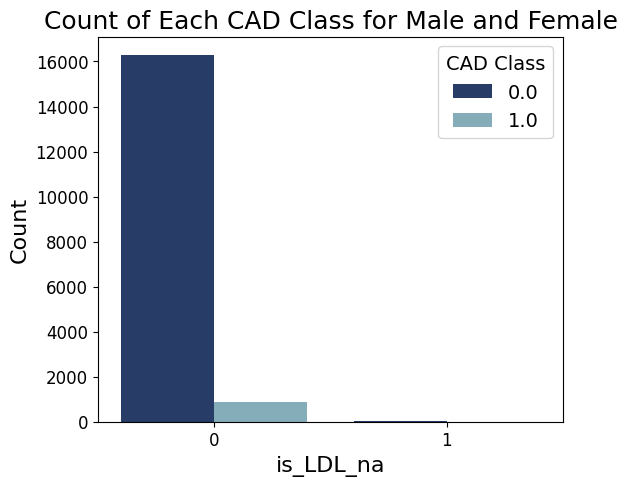

In [ ]:
### Create new variable to denote missingness in LDL
# Create a binary indicator column 'is_[]_na' to represent missing values in the '[]' column
df_most_recent['is_LDL_na'] = df_most_recent['LDL'].isna().astype(int)

### Create plot ------------------------------------------------------------------------------------------------------------------------
# Define a list of colors for the countplot
colors = ['#1c3a73', '#7cb1c2']

# Create a grouped bar chart using seaborn's countplot function with specified colors
plt.figure(figsize=(6, 5))
sns.countplot(data=df_most_recent, x='is_LDL_na', hue='[CAD)', palette=colors)

# Set labels and title for the plot
plt.xlabel('is_LDL_na')
plt.ylabel('Count')
plt.title('Count of Each CAD Class for Male and Female')
plt.legend(title='CAD Class')
plt.show()

# Remove the 'is_LDL_na' column from the DataFrame
df_most_recent.drop('is_LDL_na', axis=1, inplace=True)

In [ ]:
df_most_recent['is_HDL_na'] = df_most_recent['HDL'].isna().astype(int)

data_male = df_most_recent[df_most_recent['Sex'] == 0]
hdl_cad_tableM = pd.crosstab(data_male['is_HDL_na'], data_male['[CAD)'])
print("\nMale Counts:")
print(hdl_cad_tableM)
print("\nM Row %:")
print(pd.crosstab(data_male['is_HDL_na'], data_male['[CAD)'], normalize='index').round(3))

data_female = df_most_recent[df_most_recent['Sex'] == 1]
hdl_cad_tableF = pd.crosstab(data_female['is_HDL_na'], data_female['[CAD)'])
print("\nFemale Counts:")
print(hdl_cad_tableF)
print("\nF Row %:")
print(pd.crosstab(data_female['is_HDL_na'], data_female['[CAD)'], normalize='index').round(3))

hdl_cad_table = pd.crosstab(df_most_recent['is_HDL_na'], df_most_recent['[CAD)'])
print("\nAll Counts:")
print(hdl_cad_table)
print("\n All Row %:")
print(pd.crosstab(df_most_recent['is_HDL_na'], df_most_recent['[CAD)'], normalize='index').round(3))

del data_male
del data_female
del hdl_cad_tableM
del hdl_cad_tableF
df_most_recent.drop('is_HDL_na', axis=1, inplace=True)


Male Counts:
[CAD)       0.0  1.0
is_HDL_na           
0          5676  469
1            60    3

M Row %:
[CAD)        0.0    1.0
is_HDL_na              
0          0.924  0.076
1          0.952  0.048

Female Counts:
[CAD)        0.0  1.0
is_HDL_na            
0          10477  391
1            114    0

F Row %:
[CAD)        0.0    1.0
is_HDL_na              
0          0.964  0.036
1          1.000  0.000

All Counts:
[CAD)        0.0  1.0
is_HDL_na            
0          16153  860
1            174    3

 All Row %:
[CAD)        0.0    1.0
is_HDL_na              
0          0.949  0.051
1          0.983  0.017


In [ ]:
df_most_recent['is_TG_na'] = df_most_recent['TG'].isna().astype(int)

data_male = df_most_recent[df_most_recent['Sex'] == 0]
tg_cad_tableM = pd.crosstab(data_male['is_TG_na'], data_male['[CAD)'])
print("\nMale Counts:")
print(tg_cad_tableM)
print("\nM Row %:")
print(pd.crosstab(data_male['is_TG_na'], data_male['[CAD)'], normalize='index').round(3))

data_female = df_most_recent[df_most_recent['Sex'] == 1]
tg_cad_tableF = pd.crosstab(data_female['is_TG_na'], data_female['[CAD)'])
print("\nFemale Counts:")
print(tg_cad_tableF)
print("\nF Row %:")
print(pd.crosstab(data_female['is_TG_na'], data_female['[CAD)'], normalize='index').round(3))

tg_cad_table = pd.crosstab(df_most_recent['is_TG_na'], df_most_recent['[CAD)'])
print("\nAll Counts:")
print(tg_cad_table)
print("\n All Row %:")
print(pd.crosstab(df_most_recent['is_TG_na'], df_most_recent['[CAD)'], normalize='index').round(3))

del data_male
del data_female
del tg_cad_tableM
del tg_cad_tableF
df_most_recent.drop('is_TG_na', axis=1, inplace=True)


Male Counts:
[CAD)      0.0  1.0
is_TG_na           
0         5697  470
1           39    2

M Row %:
[CAD)       0.0    1.0
is_TG_na              
0         0.924  0.076
1         0.951  0.049

Female Counts:
[CAD)       0.0  1.0
is_TG_na            
0         10459  390
1           132    1

F Row %:
[CAD)       0.0    1.0
is_TG_na              
0         0.964  0.036
1         0.992  0.008

All Counts:
[CAD)       0.0  1.0
is_TG_na            
0         16156  860
1           171    3

 All Row %:
[CAD)       0.0    1.0
is_TG_na              
0         0.949  0.051
1         0.983  0.017


It seems that cholesterol measurements, such as LDL, HDL, & TG levels, may be missing at random (MAR).

In [ ]:
# Drop Missing Values - Limitations
df_final = df_most_recent.dropna(subset=['LDL', 'HDL', 'TG'])
df_final.shape

(16845, 9)

In [ ]:
df_final.isnull().sum()

,0
Age_at_Exam,0
Sex,0
LDL,0
HDL,0
TG,0
BMI,0
[Anxiety),0
[Depression),0
[CAD),0


In [ ]:
df_final.describe()

,Age_at_Exam,Sex,LDL,HDL,TG,BMI,[Anxiety),[Depression),[CAD)
count,16845.000000,16845.000000,16845.000000,16845.000000,16845.000000,16845.000000,16845.000000,16845.000000,16845.000000
mean,59.452775,0.638468,2.803556,1.442777,1.375279,28.567611,0.358326,0.218462,0.050341
std,15.288176,0.480458,0.929361,0.427872,0.894587,6.591607,0.479523,0.413215,0.218655
min,18.000000,0.000000,0.200000,0.130000,0.210000,11.527430,0.000000,0.000000,0.000000
25%,49.000000,0.000000,2.120000,1.130000,0.850000,24.280264,0.000000,0.000000,0.000000
50%,60.000000,1.000000,2.750000,1.380000,1.180000,27.570000,0.000000,0.000000,0.000000
75%,71.000000,1.000000,3.410000,1.690000,1.680000,31.470000,1.000000,0.000000,0.000000
max,90.000000,1.000000,8.190000,4.280000,57.340000,218.700000,1.000000,1.000000,1.000000


# Assessing Collinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Prepare predictors (exclude target)
X = df_final.drop(columns=['[CAD)'])

# Add constant for VIF calculation
X_const = add_constant(X)

# VIF -  Variance Inflation Factor, measures multicollinearity in regression models
# Compute VIF for each predictor
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i)
                    for i in range(X_const.shape[1])]

# Display VIF results
print(vif_data)

        feature        VIF
0         const  75.066908
1   Age_at_Exam   1.108423
2           Sex   1.200283
3           LDL   1.050119
4           HDL   1.405843
5            TG   1.172131
6           BMI   1.119589
7     [Anxiety)   1.096780
8  [Depression)   1.072572


# Model Pipeline

## Split Train and Test

In [ ]:
# Psychological + Demographic
x_psych = df_final[['Age_at_Exam', 'Sex','[Anxiety)', '[Depression)']]

y = df_final[['[CAD)']]

x_p_train, x_p_test, y_p_train, y_p_test = train_test_split(x_psych, y, test_size=0.2, random_state=42) # 80/20 split

In [ ]:
# Clinical + Demographic
x_clin = df_final[['Age_at_Exam', 'Sex', 'LDL', 'HDL', 'TG', 'BMI']]

y = df_final[['[CAD)']]

x_c_train, x_c_test, y_c_train, y_c_test = train_test_split(x_clin, y, test_size=0.2, random_state=42) # 80/20 split

In [ ]:
# Psychological + Clinical + Demographic
x_both = df_final[['Age_at_Exam', 'Sex', 'LDL', 'HDL', 'TG', 'BMI', '[Anxiety)', '[Depression)']]

y = df_final[['[CAD)']]

x_train, x_test, y_train, y_test = train_test_split(x_both, y, test_size=0.2, random_state=42) # 80/20 split

## Class Imbalance

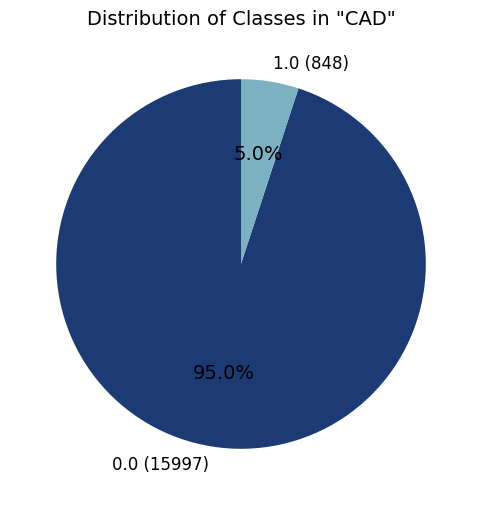

In [ ]:
### Create a pie chart to show the distribution of categories in the 'Class/ASD' variable --------------
# Count occurrences of each class in our variable of interest
counts = df_final['[CAD)'].value_counts()

# Define colors
colors = ['#1c3a73', '#7cb1c2']

# Create pie chart
plt.figure(figsize=(6, 6)) #tuple for fig size, 6x6 inches
plt.pie(
    counts, #counts for each class
    labels=[f'{cls} ({count})' for cls, count in counts.items()],  # add labels with counts... counts.items() returns an iterable of tuples
                                                                    #e.g., [('class', count)], which are then unpacked and formatted into labels
    autopct='%1.1f%%',  # Show percentages
    colors=colors,
    startangle=90
)

# Set title
plt.title('Distribution of Classes in "CAD"', fontsize=14)

# Show plot
plt.show()



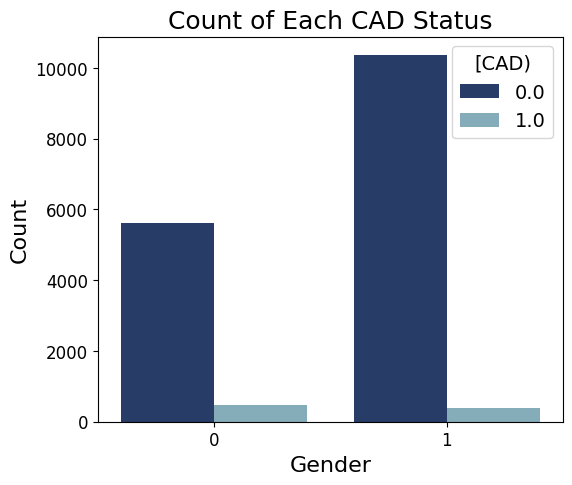

In [ ]:
### Here will will explore the distribution of 'CAD' by Sex
### Create plot
# Define a list of colors
colors = ['#1c3a73', '#7cb1c2']

# Create the grouped bar chart using seaborn's countplot function with specified colors
plt.figure(figsize=(6, 5))
sns.countplot(data=df_final, x='Sex', hue='[CAD)', palette=colors)

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Count of Each CAD Status')
plt.legend(title='[CAD)')
plt.show()


## K-Fold Cross Validation - HyperParameter Tuning

In [ ]:
# Split training set into train and validation set
x_p_train_2, x_p_val, y_p_train_2, y_p_val = train_test_split(
    x_p_train, y_p_train, test_size=0.2, random_state=42)

In [ ]:
x_c_train_2, x_c_val, y_c_train_2, y_c_val = train_test_split(
    x_c_train, y_c_train, test_size=0.2, random_state=42)

In [ ]:
x_train_2, x_val, y_train_2, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
x_p_train_2 = scaler.fit_transform(x_p_train_2)
x_p_val = scaler.transform(x_p_val)

x_c_train_2 = scaler.fit_transform(x_c_train_2)
x_c_val = scaler.transform(x_c_val)

x_train_2 = scaler.fit_transform(x_train_2)
x_val = scaler.transform(x_val)

In [ ]:
# Experimental Iteration: Initialize SMOTETomek
smt = SMOTETomek(random_state=42)

# Resample the training data only
x_train_p_res, y_train_p_res = smt.fit_resample(x_p_train_2, y_p_train_2)

In [ ]:
smt = SMOTETomek(random_state=42)
x_train_c_res, y_train_c_res = smt.fit_resample(x_c_train_2, y_c_train_2)

In [ ]:
smt = SMOTETomek(random_state=42)
x_train_res, y_train_res = smt.fit_resample(x_train, y_train)

### K-Nearest Neighbours

In [ ]:
knn = KNeighborsClassifier()

# Define the hyperparameter values that should be tested
param_dist = {'n_neighbors' : [5, 10, 15, 20, 25, 30],
               'weights' : ['distance'],
               'metric' : ['minkowski','euclidean','manhattan']
}

# Setting up Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5)

#### Psychological Features

In [ ]:
knn = KNeighborsClassifier()
# Initialize Grid Search with the model and the hyperparameters to search
hp_search_knn_p = GridSearchCV(
    knn,
    param_grid=param_dist,
    cv=skf,
    scoring='f1'
)

# Train Grid Search on the training data
hp_search_knn_p.fit(x_train_p_res, y_train_p_res)

# Extract results into a DataFrame
results_knn_p = pd.DataFrame(hp_search_knn_p.cv_results_)

# Display the set of parameters that achieved the best score
results_knn_p[results_knn_p['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.020985,0.010207,0.086794,0.005821,minkowski,5,distance,"{'metric': 'minkowski', 'n_neighbors': 5, 'wei...",0.400155,0.536861,0.508524,0.515009,0.50438,0.492986,0.047747,1
6,0.016565,0.001017,0.090216,0.004971,euclidean,5,distance,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.400155,0.536861,0.508524,0.515009,0.50438,0.492986,0.047747,1
12,0.029486,0.003934,0.187300,0.006996,manhattan,5,distance,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.400155,0.536861,0.508524,0.515009,0.50438,0.492986,0.047747,1


In [ ]:
knn = KNeighborsClassifier()

# Updating the model's parameters with the best ones found from GridSearchCV
knn_p = knn.set_params(**hp_search_knn_p.best_params_)

# Retraining the model with the best parameters on the training dataset
knn_p = knn_p.fit(x_train_p_res, y_train_p_res)

# Predicting on the training dataset and computing the accuracy
y_p_pred = knn_p.predict(x_train_p_res)
print('\n','Training Accuracy:', accuracy_score(y_train_p_res, y_p_pred))
print(' Training F1-Score:', f1_score(y_train_p_res, y_p_pred))

# Predicting on the validation dataset and computing the accuracy
y_p_pred = knn_p.predict(x_p_val)
print('\n', 'Validation Accuracy:', accuracy_score(y_p_val, y_p_pred))
print(' Validation F1-Score:', f1_score(y_p_val, y_p_pred))


 Training Accuracy: 0.6899872885499169
 Training F1-Score: 0.5522208883553421

 Validation Accuracy: 0.9454747774480712
 Validation F1-Score: 0.013422818791946308


#### Clinical Features

In [ ]:
knn = KNeighborsClassifier()

hp_search_knn_c = GridSearchCV(
    knn,
    param_grid=param_dist,
    cv=skf,
    scoring='f1'
)

hp_search_knn_c.fit(x_train_c_res, y_train_c_res)

results_knn_c = pd.DataFrame(hp_search_knn_c.cv_results_)

results_knn_c[results_knn_c['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.039419,0.037595,0.088234,0.001970,minkowski,5,distance,"{'metric': 'minkowski', 'n_neighbors': 5, 'wei...",0.905113,0.901025,0.898313,0.908315,0.89405,0.901363,0.005006,1
6,0.020584,0.000381,0.088145,0.002433,euclidean,5,distance,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.905113,0.901025,0.898313,0.908315,0.89405,0.901363,0.005006,1


In [ ]:
knn = KNeighborsClassifier()

knn_c = knn.set_params(**hp_search_knn_c.best_params_)

knn_c = knn_c.fit(x_train_c_res, y_train_c_res)

y_c_pred = knn_c.predict(x_train_c_res)
print('\n', 'Training Accuracy:', accuracy_score(y_train_c_res, y_c_pred))
print(' Training F1-Score:', f1_score(y_train_c_res, y_c_pred))

y_c_pred = knn_c.predict(x_c_val)
print('\n', 'Validation Accuracy:', accuracy_score(y_c_val, y_c_pred))
print(' Validation F1-Score:', f1_score(y_c_val, y_c_pred))


 Training Accuracy: 1.0
 Training F1-Score: 1.0

 Validation Accuracy: 0.7685459940652819
 Validation F1-Score: 0.168


#### All Features

In [ ]:
knn = KNeighborsClassifier()

hp_search_knn = GridSearchCV(
    knn,
    param_grid=param_dist,
    cv=skf,
    scoring='f1'
)

hp_search_knn.fit(x_train_res, y_train_res)

results_knn = pd.DataFrame(hp_search_knn.cv_results_)

results_knn[results_knn['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,0.100318,0.019222,0.40877,0.10095,manhattan,5,distance,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.902718,0.912135,0.901052,0.905214,0.900641,0.904352,0.004211,1


In [ ]:
knn = KNeighborsClassifier()

knn = knn.set_params(**hp_search_knn.best_params_)

knn = knn.fit(x_train_res, y_train_res)

y_pred = knn.predict(x_train_res)
print('\n', 'Training Accuracy:', accuracy_score(y_train_res, y_pred))
print(' Training F1-Score:', f1_score(y_train_res, y_pred))

y_pred = knn.predict(x_val)
print('\n', 'Validation Accuracy:', accuracy_score(y_val, y_pred))
print(' Validation F1-Score:', f1_score(y_val, y_pred))


 Training Accuracy: 1.0
 Training F1-Score: 1.0

 Validation Accuracy: 0.9499258160237388
 Validation F1-Score: 0.0


## Logistic Regression

In [ ]:
# Initialize Logistic Regression
# solver='liblinear' or 'lbfgs' both support L2 (Ridge)
lr = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# Define the grid for the regularization strength 'C'
# and toggle class_weight to see the impact
param_grid_lr = {
    'C': [10, 25, 50, 75, 100],
    'class_weight': ['balanced']
}

#### Psychological Features

In [ ]:
lr = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# Initialize Grid Search
hp_search_lr_p = GridSearchCV(
    lr,
    param_grid=param_grid_lr,
    cv=skf,
    scoring='f1'
)

# Train Grid Search on the training data
hp_search_lr_p.fit(x_train_p_res, y_train_p_res)

# Extract results into a DataFrame
results_lr_p = pd.DataFrame(hp_search_lr_p.cv_results_)

# Display the set of parameters that achieved the best score
results_lr_p[results_lr_p['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.055071,0.038157,0.031510,0.027618,10,balanced,"{'C': 10, 'class_weight': 'balanced'}",0.690602,0.693897,0.689869,0.706667,0.704132,0.697033,0.00701,1
1,0.036860,0.015426,0.015512,0.001476,25,balanced,"{'C': 25, 'class_weight': 'balanced'}",0.690602,0.693897,0.689869,0.706667,0.704132,0.697033,0.00701,1
2,0.037880,0.013278,0.020806,0.008600,50,balanced,"{'C': 50, 'class_weight': 'balanced'}",0.690602,0.693897,0.689869,0.706667,0.704132,0.697033,0.00701,1
3,0.051038,0.016511,0.035625,0.020731,75,balanced,"{'C': 75, 'class_weight': 'balanced'}",0.690602,0.693897,0.689869,0.706667,0.704132,0.697033,0.00701,1
4,0.036421,0.010428,0.027417,0.013888,100,balanced,"{'C': 100, 'class_weight': 'balanced'}",0.690602,0.693897,0.689869,0.706667,0.704132,0.697033,0.00701,1


In [ ]:
lr = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# Updating the model's parameters with the best ones found from GridSearchCV
lr_p = lr.set_params(**hp_search_lr_p.best_params_)

# Retraining the model with the best parameters on the training dataset
lr_p = lr_p.fit(x_train_p_res, y_train_p_res)

# Predicting on the training dataset and computing the accuracy
y_p_pred = lr_p.predict(x_train_p_res)
print('\n','Training Accuracy:', accuracy_score(y_train_p_res, y_p_pred))
print(' Training F1-Score:', f1_score(y_train_p_res, y_p_pred))

# Predicting on the validation dataset and computing the accuracy
y_p_pred = lr_p.predict(x_p_val)
print('\n', 'Validation Accuracy:', accuracy_score(y_p_val, y_p_pred))
print(' Validation F1-Score:', f1_score(y_p_val, y_p_pred))


 Training Accuracy: 0.6899872885499169
 Training F1-Score: 0.6973125208840517

 Validation Accuracy: 0.6661721068249258
 Validation F1-Score: 0.1773308957952468


#### Clinical Features

In [ ]:
lr = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# Initialize Grid Search
hp_search_lr_c = GridSearchCV(
    lr,
    param_grid=param_grid_lr,
    cv=skf,
    scoring='f1'
)

# Train Grid Search on the training data
hp_search_lr_c.fit(x_train_c_res, y_train_c_res)

# Extract results into a DataFrame
results_lr_c = pd.DataFrame(hp_search_lr_c.cv_results_)

# Display the set of parameters that achieved the best score
results_lr_c[results_lr_c['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.174167,0.068861,0.081206,0.039203,10,balanced,"{'C': 10, 'class_weight': 'balanced'}",0.723508,0.73108,0.714116,0.740334,0.733871,0.728582,0.009026,1


In [ ]:
lr = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# Updating the model's parameters with the best ones found from GridSearchCV
lr_c = lr.set_params(**hp_search_lr_c.best_params_)

# Retraining the model with the best parameters on the training dataset
lr_c = lr_c.fit(x_train_c_res, y_train_c_res)

# Predicting on the training dataset and computing the accuracy
y_c_pred = lr_c.predict(x_train_c_res)
print('\n','Training Accuracy:', accuracy_score(y_train_c_res, y_c_pred))
print(' Training F1-Score:', f1_score(y_train_c_res, y_c_pred))

# Predicting on the validation dataset and computing the accuracy
y_c_pred = lr_c.predict(x_c_val)
print('\n', 'Validation Accuracy:', accuracy_score(y_c_val, y_c_pred))
print(' Validation F1-Score:', f1_score(y_c_val, y_c_pred))


 Training Accuracy: 0.7214728758491681
 Training F1-Score: 0.7295152500239028

 Validation Accuracy: 0.6865727002967359
 Validation F1-Score: 0.1882804995196926


#### All Features

In [ ]:
lr = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# Initialize Grid Search
hp_search_lr = GridSearchCV(
    lr,
    param_grid=param_grid_lr,
    cv=skf,
    scoring='f1'
)

# Train Grid Search on the training data
hp_search_lr.fit(x_train_res, y_train_res)

# Extract results into a DataFrame
results_lr = pd.DataFrame(hp_search_lr.cv_results_)

# Display the set of parameters that achieved the best score
results_lr[results_lr['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.182002,0.048302,0.047099,0.020822,10,balanced,"{'C': 10, 'class_weight': 'balanced'}",0.729944,0.761905,0.762178,0.770933,0.765015,0.757995,0.014397,1
1,0.212227,0.054527,0.039796,0.019946,25,balanced,"{'C': 25, 'class_weight': 'balanced'}",0.729944,0.761905,0.762178,0.770933,0.765015,0.757995,0.014397,1
4,0.257507,0.053238,0.036662,0.008056,100,balanced,"{'C': 100, 'class_weight': 'balanced'}",0.729944,0.761905,0.762178,0.770933,0.765015,0.757995,0.014397,1


In [ ]:
lr = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# Updating the model's parameters with the best ones found from GridSearchCV
lr = lr.set_params(**hp_search_lr.best_params_)

# Retraining the model with the best parameters on the training dataset
lr = lr.fit(x_train_res, y_train_res)

# Predicting on the training dataset and computing the accuracy
y_pred = lr.predict(x_train_res)
print('\n','Training Accuracy:', accuracy_score(y_train_res, y_pred))
print(' Training F1-Score:', f1_score(y_train_res, y_pred))

# Predicting on the validation dataset and computing the accuracy
y_pred = lr.predict(x_val)
print('\n', 'Validation Accuracy:', accuracy_score(y_val, y_pred))
print(' Validation F1-Score:', f1_score(y_val, y_pred))


 Training Accuracy: 0.7512766124597376
 Training F1-Score: 0.7580065734158832

 Validation Accuracy: 0.8000741839762612
 Validation F1-Score: 0.19672131147540983


## Model Evaluation

--- Final Model Classification Report ---
              precision    recall  f1-score   support

         0.0       0.97      0.72      0.83      3203
         1.0       0.11      0.63      0.18       166

    accuracy                           0.72      3369
   macro avg       0.54      0.68      0.51      3369
weighted avg       0.93      0.72      0.80      3369



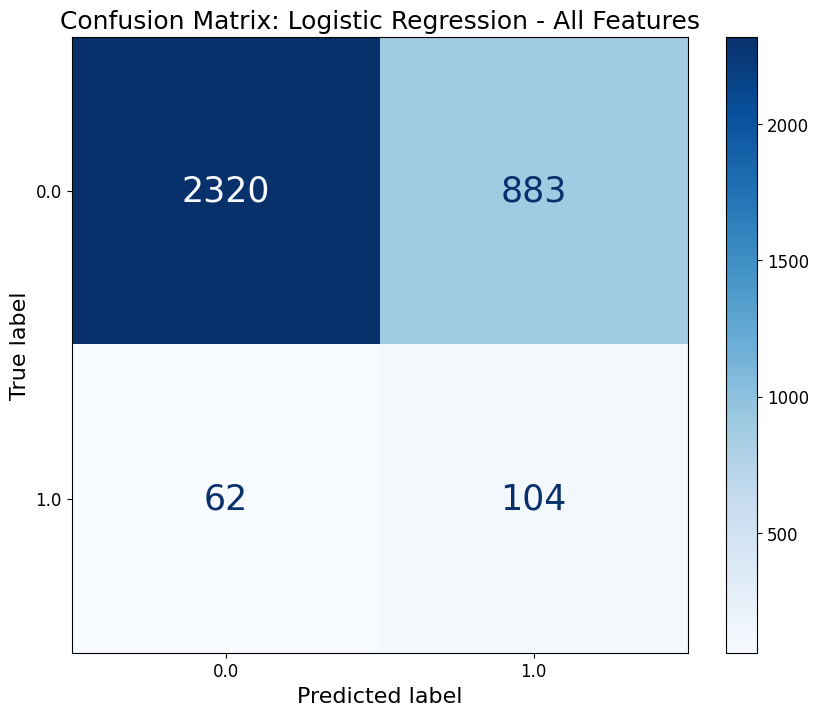

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set global font sizes for all plot elements
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels

y_pred = lr.predict(x_test)

print("--- Final Model Classification Report ---")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')

# Increase font size of the numbers inside the matrix cells
for labels in disp.text_.ravel():
    labels.set_fontsize(25)

plt.title('Confusion Matrix: Logistic Regression - All Features')
plt.show()

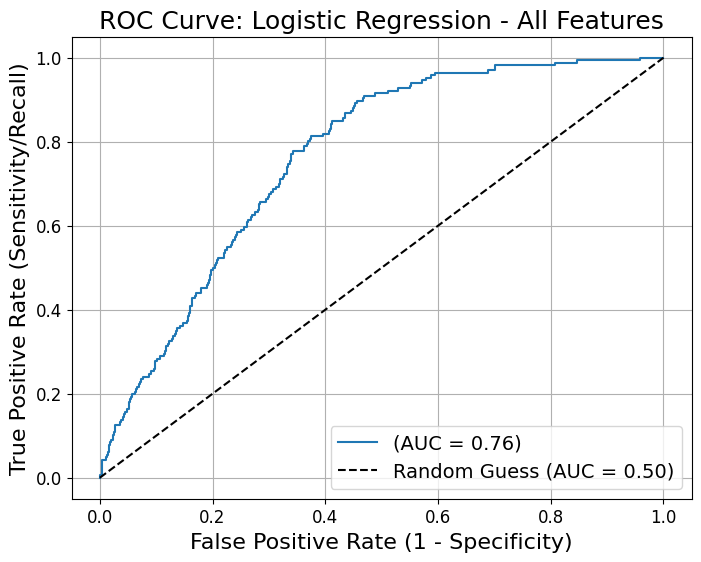

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# We use probabilities for the ROC curve
y_probs = lr.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'(AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('ROC Curve: Logistic Regression - All Features')
plt.legend()
plt.grid(True)
plt.show()